
# 04 — Model Comparison: Baselines, XGB, STL+XGB, and N-BEATS





##  Setup & configuration



In [1]:

# --- Configuration ---
PROJECT = "ssta_plymouth"          # change if needed, e.g., "ssta_plymouth"
PROCESSED_DIR = "../data/processed"

import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def detect_metrics_path(stem: str, project: str) -> Path:
    cand = Path(PROCESSED_DIR) / f"{stem}_{project}.csv"
    if cand.exists():
        return cand
    matches = sorted(Path(PROCESSED_DIR).glob(f"{stem}_*.csv"))
    if not matches:
        raise FileNotFoundError(f"No {stem}_<project>.csv found in {PROCESSED_DIR}")
    return matches[-1]

def detect_preds_path(stem: str, project: str) -> Path:
    cand = Path(PROCESSED_DIR) / f"{stem}_{project}.parquet"
    if cand.exists():
        return cand
    matches = sorted(Path(PROCESSED_DIR).glob(f"{stem}_*.parquet"))
    if not matches:
        raise FileNotFoundError(f"No {stem}_<project>.parquet found in {PROCESSED_DIR}")
    return matches[-1]



## 1. Load artifacts
We expect:
- Baselines: `metrics_<project>.csv`, `preds_<project>.parquet`
- XGB: `metrics_xgb_<project>.csv`, `preds_xgb_<project>.parquet`
- STL+XGB: `metrics_stl_xgb_<project>.csv`, `preds_stl_xgb_<project>.parquet`
- N-BEATS: `metrics_nbeats_<project>.csv`, `preds_nbeats_<project>.parquet`


In [2]:

# Locate files
m_base = detect_metrics_path("metrics", PROJECT)
p_base = detect_preds_path("preds", PROJECT)

m_xgb  = detect_metrics_path("metrics_xgb", PROJECT)
p_xgb  = detect_preds_path("preds_xgb", PROJECT)

m_stl  = detect_metrics_path("metrics_stl_xgb", PROJECT)
p_stl  = detect_preds_path("preds_stl_xgb", PROJECT)

m_nb   = detect_metrics_path("metrics_nbeats", PROJECT)
p_nb   = detect_preds_path("preds_nbeats", PROJECT)

print("Loaded:")
print(" ", m_base.name, p_base.name)
print(" ", m_xgb.name,  p_xgb.name)
print(" ", m_stl.name,  p_stl.name)
print(" ", m_nb.name,   p_nb.name)

# Read all
metrics_base = pd.read_csv(m_base)
metrics_xgb  = pd.read_csv(m_xgb)
metrics_stl  = pd.read_csv(m_stl)
metrics_nb   = pd.read_csv(m_nb)

def load_preds(path: Path) -> pd.DataFrame:
    df = pd.read_parquet(path)
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    return df.dropna(subset=["date"]).sort_values(["date","horizon","model"]).reset_index(drop=True)

preds_base = load_preds(p_base)
preds_xgb  = load_preds(p_xgb)
preds_stl  = load_preds(p_stl)
preds_nb   = load_preds(p_nb)

# Normalize model names where missing
if "model" not in metrics_xgb.columns: metrics_xgb["model"] = "xgb_direct"
if "model" not in metrics_stl.columns: metrics_stl["model"] = "stl+xgb_resid"
if "model" not in metrics_nb.columns:  metrics_nb["model"]  = "nbeats"
if "model" not in preds_xgb.columns:   preds_xgb["model"]   = "xgb_direct"
if "model" not in preds_stl.columns:   preds_stl["model"]   = "stl+xgb_resid"
if "model" not in preds_nb.columns:    preds_nb["model"]    = "nbeats"


Loaded:
  metrics_ssta_plymouth.csv preds_ssta_plymouth.parquet
  metrics_xgb_ssta_plymouth.csv preds_xgb_ssta_plymouth.parquet
  metrics_stl_xgb_ssta_plymouth.csv preds_stl_xgb_ssta_plymouth.parquet
  metrics_nbeats_ssta_plymouth.csv preds_nbeats_ssta_plymouth.parquet



## 2. Unified leaderboards
Concatenate metrics and sort by MAE per horizon.


In [3]:

metrics_all = pd.concat([metrics_base, metrics_xgb, metrics_stl, metrics_nb], ignore_index=True, sort=False)
metrics_all = metrics_all.sort_values(["horizon","MAE"]).reset_index(drop=True)
print(metrics_all.head(16).to_string(index=False))

def leaderboard_for_h(h):
    m = metrics_all[metrics_all["horizon"] == h].copy()
    return m.sort_values("MAE")[["horizon","model","MAE","RMSE","sMAPE","MASE"]]

for h in sorted(metrics_all["horizon"].unique()):
    print("\n=== LEADERBOARD: Horizon +%d months ===" % h)
    print(leaderboard_for_h(h).to_string(index=False))


 horizon                   model      MAE     RMSE      sMAPE     MASE  Skill_vs_Climo_%
       1            nbeats(W=36) 0.409033 0.504203 115.222812      NaN               NaN
       1              xgb_direct 0.410519 0.524259 112.572362 0.688649               NaN
       1 sarima(1,0,0)(1,0,0,12) 0.439933 0.560794 112.555903 0.747585         26.105878
       1           stl+xgb_resid 0.461517 0.581361 115.001906      NaN               NaN
       1          seasonal_naive 0.588473 0.773152 130.029877 1.000000          1.156197
       1             climatology 0.595356 0.712816 163.138279 1.011697          0.000000
       3              xgb_direct 0.416868 0.525395 110.417491 0.706502               NaN
       3            nbeats(W=36) 0.458242 0.572383 125.989000      NaN               NaN
       3           stl+xgb_resid 0.471936 0.598579 114.893515      NaN               NaN
       3 sarima(1,0,0)(1,0,0,12) 0.480594 0.605365 134.919275 0.829453         19.825254
       3          sea


## 3. MAE by model per horizon
Simple bar chart per horizon.


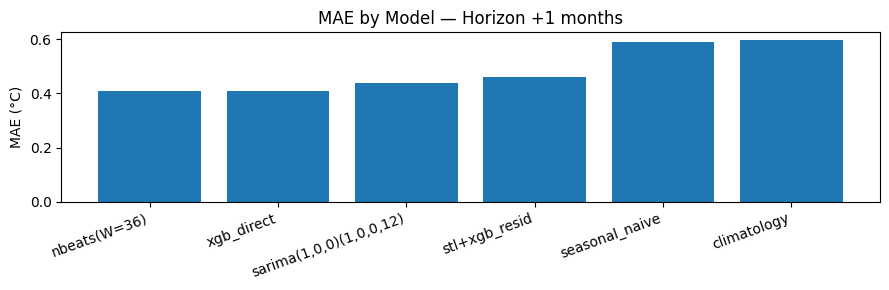

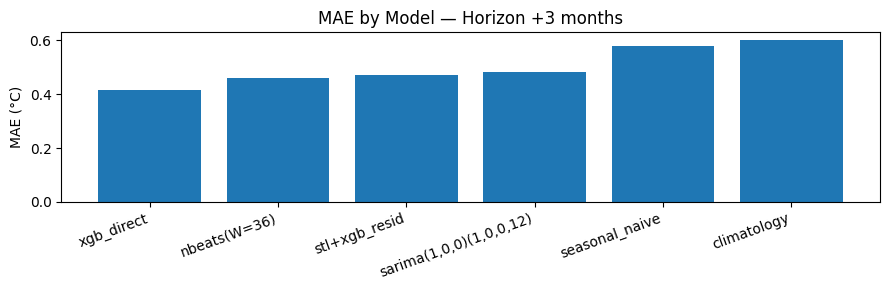

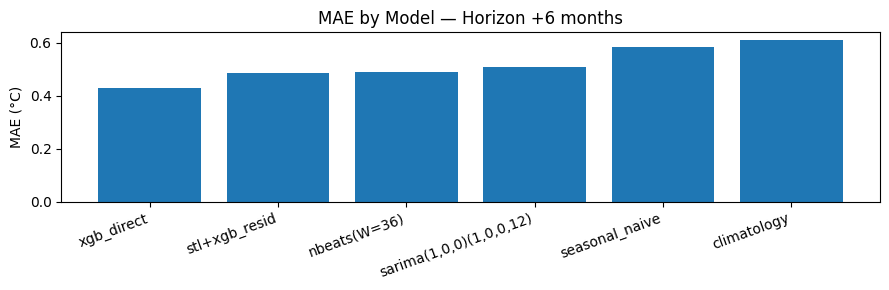

In [4]:

def plot_mae_by_model(h):
    m = metrics_all[metrics_all["horizon"] == h].copy()
    labels = m["model"].tolist()
    vals = m["MAE"].tolist()
    plt.figure(figsize=(9,3))
    plt.bar(range(len(labels)), vals)
    plt.xticks(range(len(labels)), labels, rotation=20, ha="right")
    plt.ylabel("MAE (°C)")
    plt.title(f"MAE by Model — Horizon +{h} months")
    plt.tight_layout(); plt.show()

for h in sorted(metrics_all["horizon"].unique()):
    plot_mae_by_model(int(h))



## 4. Skill vs. climatology (if available)


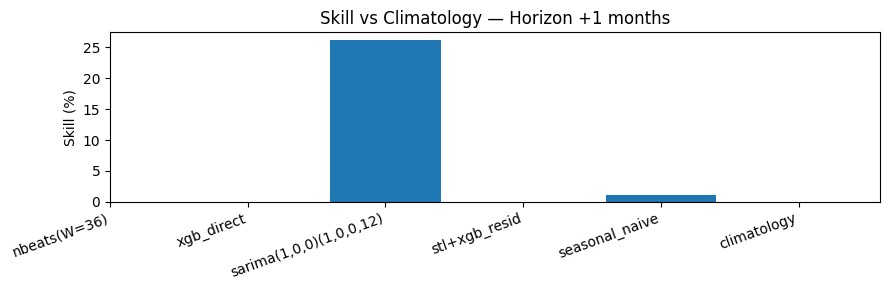

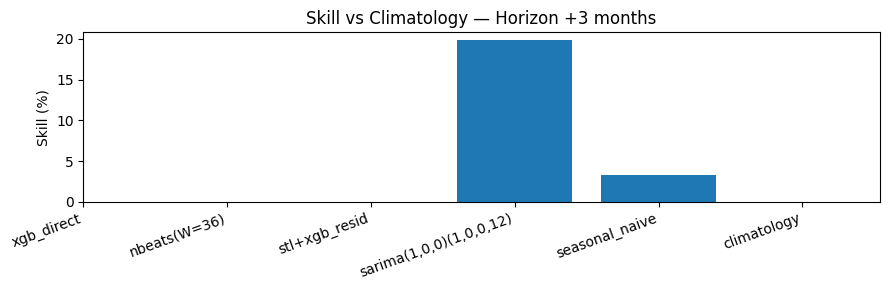

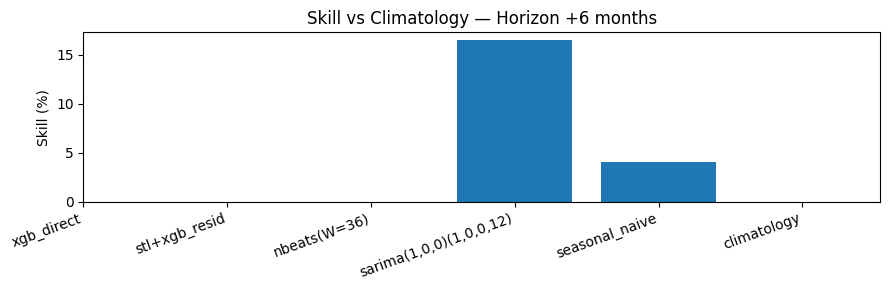

In [5]:

def plot_skill_for_h(h):
    m = metrics_all[metrics_all["horizon"] == h].copy()
    if "Skill_vs_Climo_%" not in m.columns:
        print("Skill_vs_Climo_% not found; skipping.")
        return
    labels = m["model"].tolist()
    vals = m["Skill_vs_Climo_%"].tolist()
    plt.figure(figsize=(9,3))
    plt.bar(range(len(labels)), vals)
    plt.xticks(range(len(labels)), labels, rotation=20, ha="right")
    plt.title(f"Skill vs Climatology — Horizon +{h} months")
    plt.ylabel("Skill (%)")
    plt.tight_layout(); plt.show()

if "Skill_vs_Climo_%" in metrics_all.columns:
    for h in sorted(metrics_all["horizon"].unique()):
        plot_skill_for_h(int(h))
else:
    print("No Skill_vs_Climo_% column found in any metrics table.")



## 5. Forecast vs. actuals (overlay of best model per horizon)


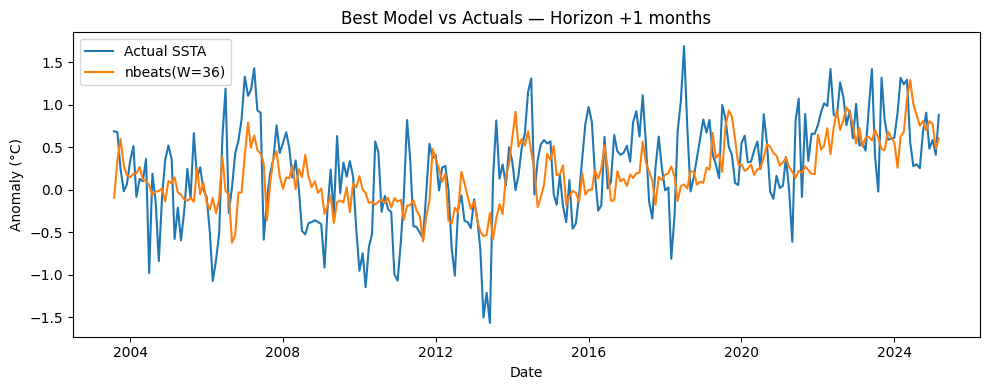

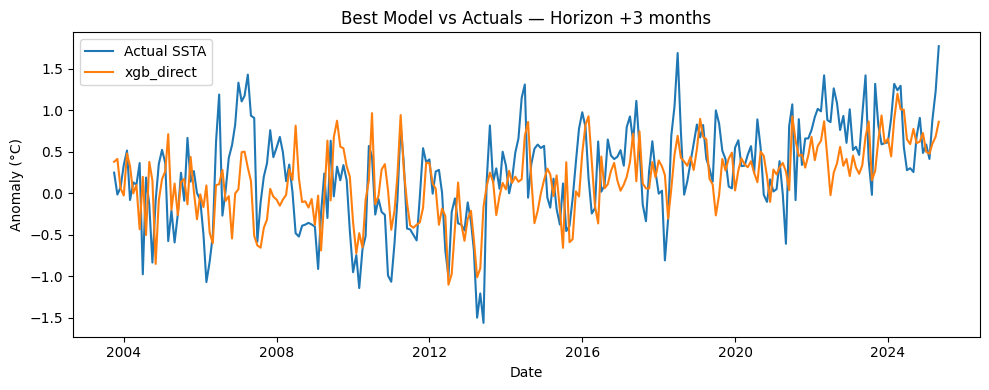

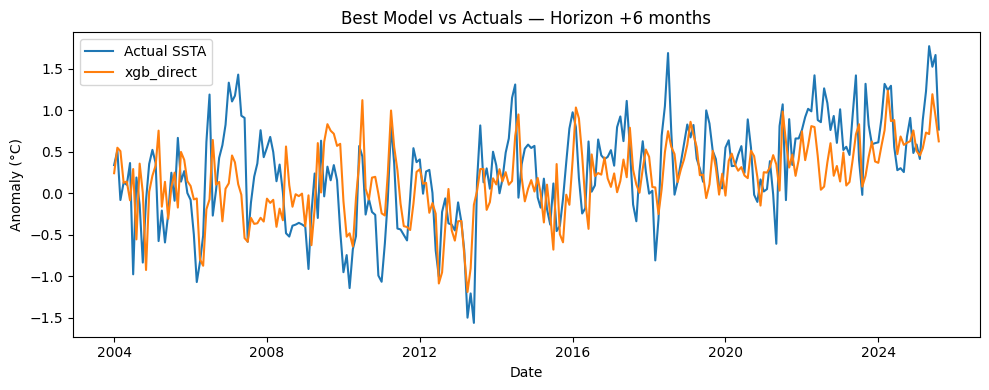

In [6]:

def get_preds_for_model(name_keyword: str):
    key = name_keyword.lower()
    if "xgb" in key and "stl" not in key: return preds_xgb
    if "stl" in key: return preds_stl
    if "nbeats" in key: return preds_nb
    return preds_base

def plot_best_overlay(h):
    m = leaderboard_for_h(h)
    best_model = str(m.iloc[0]["model"])
    source = get_preds_for_model(best_model)
    p = source[source["horizon"] == h].copy()
    if p.empty:
        print(f"No predictions for horizon={h} in {best_model}.")
        return
    actual = p[["date","y_true"]].drop_duplicates().sort_values("date")
    plt.figure(figsize=(10,4))
    plt.plot(actual["date"], actual["y_true"], label="Actual SSTA")
    pm = p[p["model"] == best_model].sort_values("date")
    plt.plot(pm["date"], pm["y_pred"], label=best_model)
    plt.title(f"Best Model vs Actuals — Horizon +{h} months")
    plt.xlabel("Date"); plt.ylabel("Anomaly (°C)")
    plt.legend()
    plt.tight_layout(); plt.show()

for h in sorted(metrics_all["horizon"].unique()):
    plot_best_overlay(int(h))



## 6. Relative improvement vs. seasonal naïve


In [7]:

def improvement_vs_seasonal_naive(h):
    m = metrics_all[metrics_all["horizon"] == h].copy()
    base = m[m["model"].str.contains("seasonal_naive")]["MAE"]
    if base.empty:
        print(f"Seasonal naïve baseline not found for h={h}.")
        return
    b = float(base.iloc[0])
    m = m.assign(Improvement_vs_Seasonal_Naive_pct = 100.0 * (1.0 - m["MAE"] / b))
    print(m[["model","MAE","Improvement_vs_Seasonal_Naive_pct"]].sort_values("MAE").to_string(index=False))

for h in sorted(metrics_all["horizon"].unique()):
    print(f"\n=== Improvement vs Seasonal Naïve — h=+{h} ===")
    improvement_vs_seasonal_naive(int(h))



=== Improvement vs Seasonal Naïve — h=+1 ===
                  model      MAE  Improvement_vs_Seasonal_Naive_pct
           nbeats(W=36) 0.409033                          30.492509
             xgb_direct 0.410519                          30.239887
sarima(1,0,0)(1,0,0,12) 0.439933                          25.241523
          stl+xgb_resid 0.461517                          21.573802
         seasonal_naive 0.588473                           0.000000
            climatology 0.595356                          -1.169721

=== Improvement vs Seasonal Naïve — h=+3 ===
                  model      MAE  Improvement_vs_Seasonal_Naive_pct
             xgb_direct 0.416868                          28.053169
           nbeats(W=36) 0.458242                          20.912438
          stl+xgb_resid 0.471936                          18.548956
sarima(1,0,0)(1,0,0,12) 0.480594                          17.054734
         seasonal_naive 0.579411                           0.000000
            climatology 